# Spectrogram Analysis

## Summary
This notebook shows you how to compute spectrograms from PMU data. It looks at the spectrograms of voltages from the NI4AI Sunshine dataset measured near a PV injection site. 

In [13]:
import btrdb
import numpy as np
import pandas as pd

from btrdb.utils.timez import ns_delta, ns_to_datetime, datetime_to_ns
from library.utils import streams_to_df, describe_streams

from scipy import signal
from scipy.signal import periodogram as PSD

import matplotlib.colors as colors
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = btrdb.connect(profile='ni4ai')
print(db.info())

{'majorVersion': 5, 'build': '5.12.5', 'proxy': {'proxyEndpoints': []}}


## Get Data Streams from BTrDB

Sunshine Impedance Data

PMU5 substation - PMU2 Building
Pos seq 0.489 + j0.59
Neg seq 0.971 + j1.476

PMU4 substation - PMU6 Building
Pos seq 0.76 + j0.463
Neg seq 1.782 + j1.234

PMU3 substation - PMU1 PV array

In [3]:
# Get voltage streams
# streams = db.streams_in_collection("sunshine/PMU2");
# downstream_solar = db.streams_in_collection("sunshine/PMU3")
solar_streams = db.streams_in_collection("sunshine/PMU1")
building2 = db.streams_in_collection("sunshine/PMU2")

# order: l2mag, l2ang, c2mag, c2ang
solar_power = [solar_streams[12], solar_streams[7], 
               solar_streams[3], solar_streams[10]]
load_power = [building2[0], building2[9], building2[2], building2[1]]

In [4]:
print(describe_streams(solar_streams))

  Index  Collection     Name    Units    UUID
-------  -------------  ------  -------  ------------------------------------
      0  sunshine/PMU1  LSTATE  mask     6ffb2e7e-273c-4963-9143-b416923980b0
      1  sunshine/PMU1  C1ANG   deg      d625793b-721f-46e2-8b8c-18f882366eeb
      2  sunshine/PMU1  C3MAG   amps     fb61e4d1-3e17-48ee-bdf3-43c54b03d7c8
      3  sunshine/PMU1  C2MAG   amps     d765f128-4c00-4226-bacf-0de8ebb090b5
      4  sunshine/PMU1  C1MAG   amps     1187af71-2d54-49d4-9027-bae5d23c4bda
      5  sunshine/PMU1  C3ANG   deg      0be8a8f4-3b45-4fe3-b77c-1cbdadb92039
      6  sunshine/PMU1  L3ANG   deg      e4efd9f6-9932-49b6-9799-90815507aed0
      7  sunshine/PMU1  L2ANG   deg      886203ca-d3e8-4fca-90cc-c88dfd0283d4
      8  sunshine/PMU1  L3MAG   volts    b2936212-253e-488a-87f6-a9927042031f
      9  sunshine/PMU1  L1ANG   deg      51840b07-297a-42e5-a73a-290c0a47bddb
     10  sunshine/PMU1  C2ANG   deg      97de3802-d38d-403c-96af-d23b874b5e95
     11  sunshine/

# Spectrogram of PV Voltage Magnitude

In [5]:
def plot_spectrogram(title='', **spec_kwargs):
    f, t, Sxx = signal.spectrogram(**spec_kwargs)

    fig, ax = plt.subplots(figsize=(12,6),nrows=2, constrained_layout=True)
    
    ax[0].plot(spec_kwargs['x'])
    spec_imag = ax[1].pcolormesh(t, f, Sxx, shading='gouraud', norm=colors.LogNorm())
    fig.colorbar(spec_imag, ax=ax[1])

    fig.supxlabel('Time')
    fig.supylabel('Frequency(Hz)')
    fig.suptitle(f'{title} spectrogram')
    plt.show()

In [7]:
start = ns_delta(minutes=1300) + load_power[0].earliest()[0].time
interval = ns_delta(days=1/2)
end = start + interval
pw = 27 #seconds2pointwidth(1)

#PMU source
Vmag = streams_to_df(load_power[0], start, end, pw=pw, agg=['mean'], to_datetime=True)
Imag = streams_to_df(load_power[2], start, end, pw=pw, agg=['mean'], to_datetime=True)

dt = (datetime_to_ns(Vmag.index[1])-datetime_to_ns(Vmag.index[0]))/1e9
fs = 1/dt
print(f'pw = {pw}, dt = {dt} seconds, fs = {round(fs,2)} Hz')

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

Getting streams:   0%|          | 0/1 [00:00<?, ?it/s]

pw = 27, dt = 0.134217984 seconds, fs = 7.45 Hz


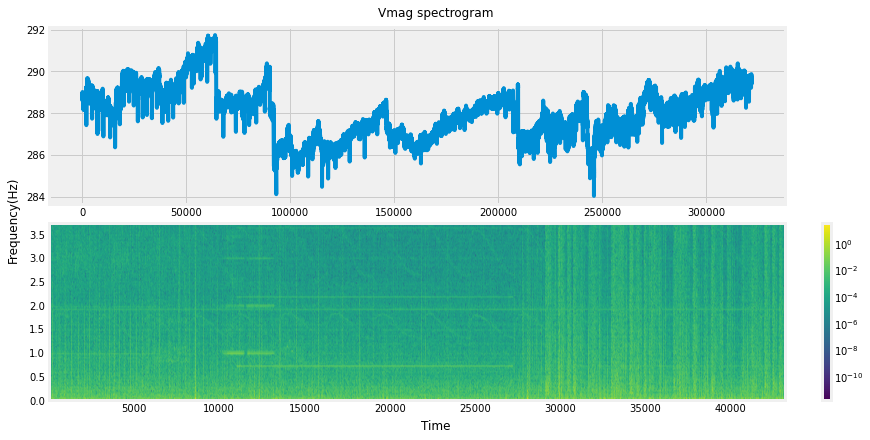

In [14]:
plot_spectrogram(x=Vmag.values.reshape(-1), fs=fs, axis=0, title='Vmag')

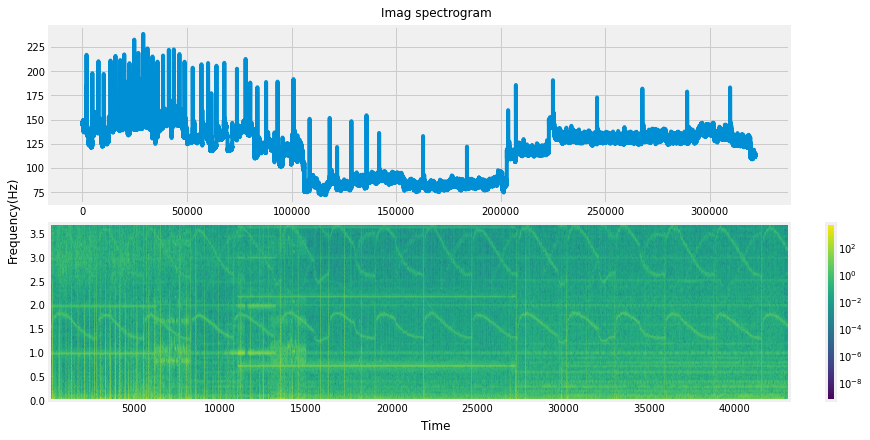

In [15]:
plot_spectrogram(x=Imag.values.reshape(-1), fs=fs, axis=0, title='Imag')

# Multiple Days Spectrogram of PV Voltage Magnitude - delete ???

pw 27


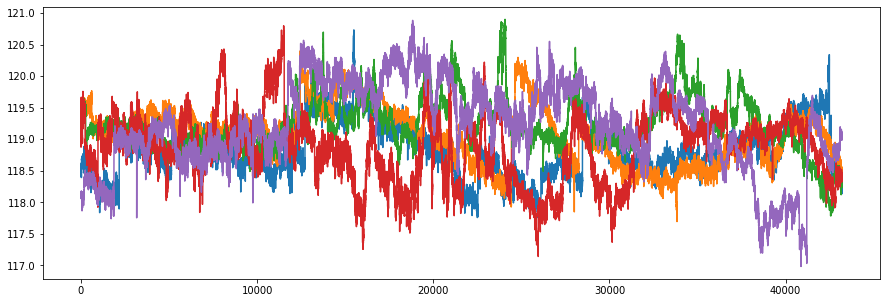

In [ ]:
day = ns_delta(days=1)
ndays = 5
start = ns_delta(minutes=1300) + load_power[0].earliest()[0].time
interval = ns_delta(days=1/2)
end = start + interval
pw = 27 #seconds2pointwidth(1)
print('pw',pw)

plt.figure(figsize=(15, 5))
times_list = []
Vmag_list = []
for i in range(ndays):
  #PMU source
    points, _ = zip(*load_power[0].aligned_windows(start, end, pointwidth=pw))
    Vmag, times = points2series(points, raw=False)
    Vmag_list.append(Vmag)
    times_list.append(times)
    plt.plot(times_list[0], Vmag)

    start = start + day
    end = start + interval


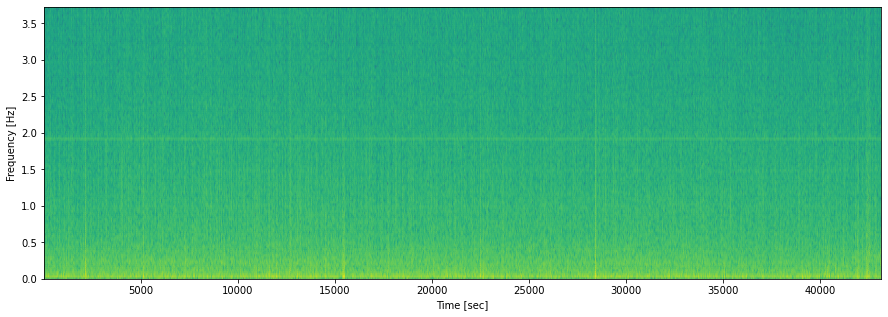

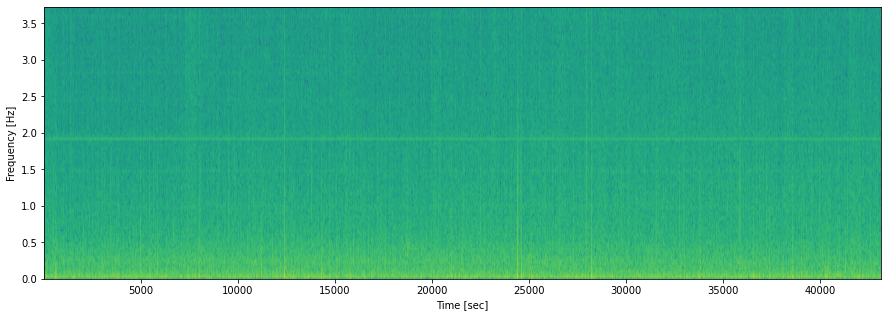

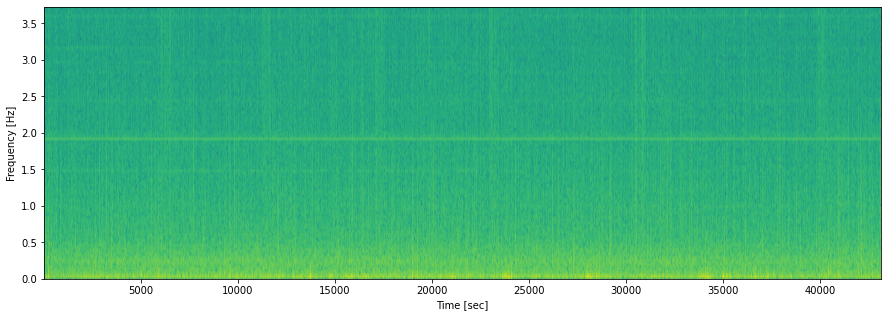

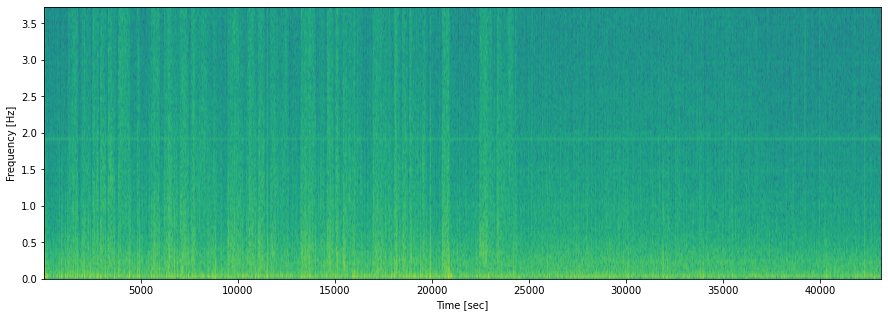

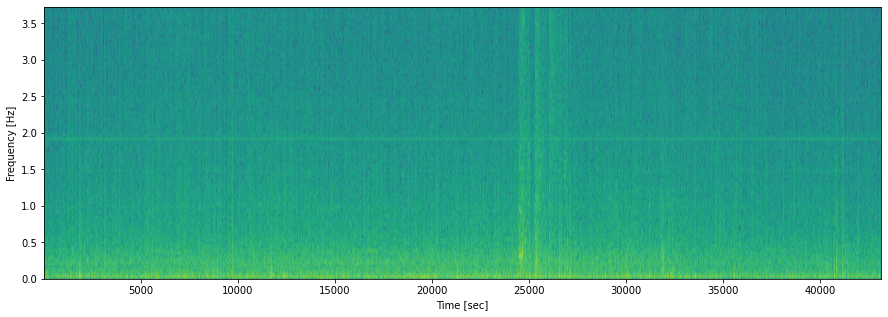

In [ ]:

#######################################
### Spectrogram of Voltage Magnitude
dt = times[1]-times[0]
fs = 1/dt

for i in range(ndays):
    f, t, Sxx = signal.spectrogram(Vmag_list[i], fs)#, window=('hann',51))
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', norm=colors.LogNorm())
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Multiple Days Spectrogram of PV Current Magnitude

pw 25


ValueError: ignored

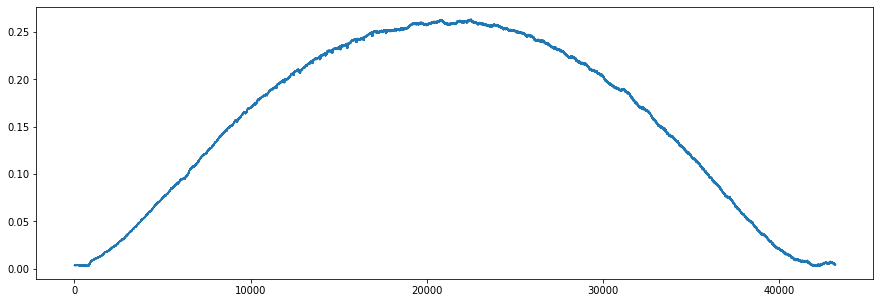

In [ ]:
day = ns_delta(days=1)
ndays = 5
start = ns_delta(minutes=1300) + load_power[0].earliest()[0].time
interval = ns_delta(days=1/2)
end = start + interval
pw = 27 #seconds2pointwidth(1)
print('pw',pw)

plt.figure(figsize=(15, 5))
times_list = []
Imag_list = []
for i in range(ndays):
  #PMU source
    points, _ = zip(*load_power[2].aligned_windows(start, end, pointwidth=pw))
    Imag, times = points2series(points, raw=False)
    Imag_list.append(Imag)
    times_list.append(times)
    plt.plot(times_list[0], Imag)

    start = start + day
    end = start + interval


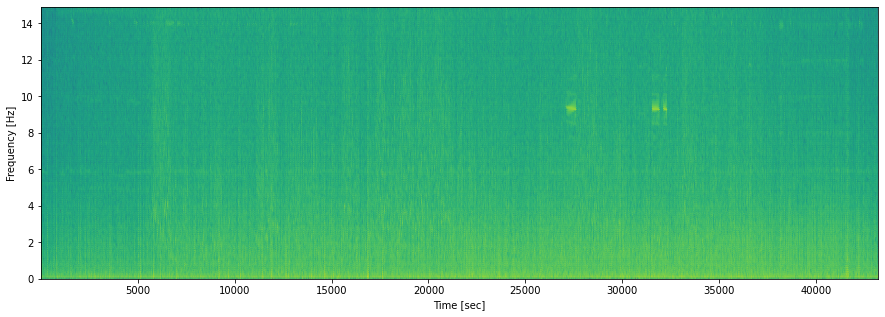

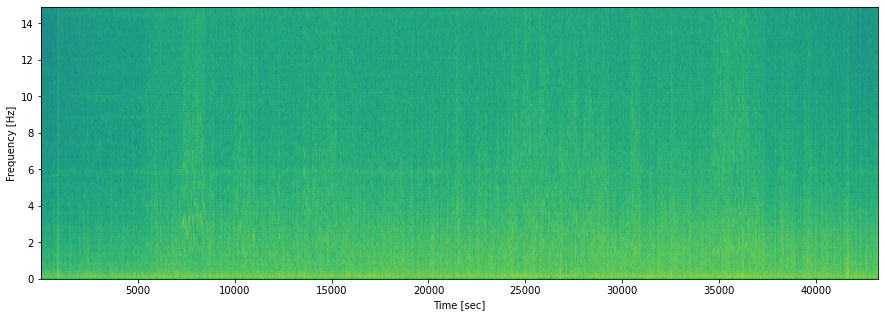

IndexError: ignored

In [ ]:

#######################################
### Spectrogram of Voltage Magnitude
dt = times[1]-times[0]
fs = 1/dt

for i in range(ndays):
    f, t, Sxx = signal.spectrogram(Imag_list[i], fs)#, window=('hann',51))
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', norm=colors.LogNorm())
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
